No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

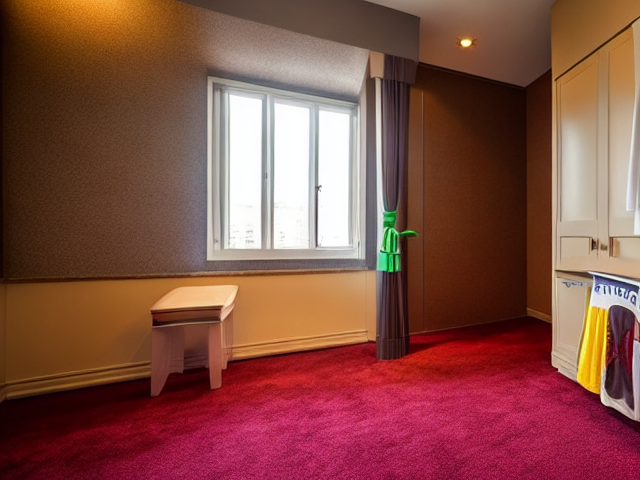

In [17]:
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

canny_image = load_image(
    '/home/yuxuan/project/Data/official_splits/test/living_room/rgb_01204.jpg'
)
canny_image = np.array(canny_image)

low_threshold = 100
high_threshold = 200

canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)

canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

from transformers import pipeline
depth_estimator = pipeline('depth-estimation')
depth_img = depth_estimator(load_image(
    '/home/yuxuan/project/Data/official_splits/test/living_room/rgb_01204.jpg'
))['depth']
depth_img = np.array(depth_img)
depth_img = depth_img[:, :, None]
depth_img = np.concatenate([depth_img, depth_img, depth_img], axis=2)
depth_img = Image.fromarray(depth_img)

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

controlnet = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
]

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

prompt = "a room"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"

generator = torch.Generator(device="cpu").manual_seed(1)

images = [depth_img, canny_image]

image = pipe(
    prompt,
    images,
    num_inference_steps=20,
    generator=generator,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=[1.0, 0.2],
).images[0]

image

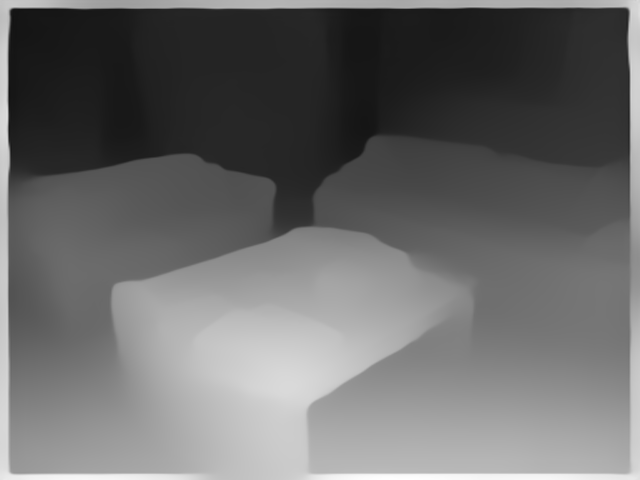

In [14]:
depth_img

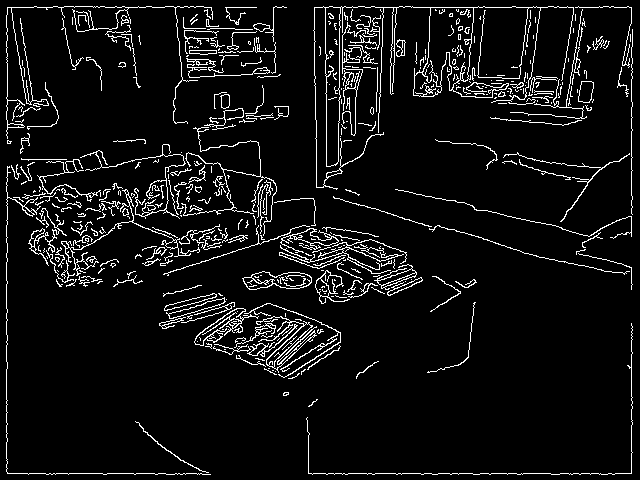

In [12]:
canny_image

In [1]:
import torch
import matplotlib
import matplotlib.cm
import numpy as np

torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True)  # Triggers fresh download of MiDaS repo
model_zoe_n = torch.hub.load("isl-org/ZoeDepth", "ZoeD_NK", pretrained=True).eval()
model_zoe_n = model_zoe_n.to("cuda")


def colorize(value, vmin=None, vmax=None, cmap='gray_r', invalid_val=-99, invalid_mask=None, background_color=(128, 128, 128, 255), gamma_corrected=False, value_transform=None):
    if isinstance(value, torch.Tensor):
        value = value.detach().cpu().numpy()

    value = value.squeeze()
    if invalid_mask is None:
        invalid_mask = value == invalid_val
    mask = np.logical_not(invalid_mask)

    # normalize
    vmin = np.percentile(value[mask],2) if vmin is None else vmin
    vmax = np.percentile(value[mask],85) if vmax is None else vmax
    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)  # vmin..vmax
    else:
        # Avoid 0-division
        value = value * 0.

    # squeeze last dim if it exists
    # grey out the invalid values

    value[invalid_mask] = np.nan
    cmapper = matplotlib.cm.get_cmap(cmap)
    if value_transform:
        value = value_transform(value)
        # value = value / value.max()
    value = cmapper(value, bytes=True)  # (nxmx4)

    # img = value[:, :, :]
    img = value[...]
    img[invalid_mask] = background_color

    # gamma correction
    img = img / 255
    img = np.power(img, 2.2)
    img = img * 255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    return img


def get_zoe_depth_map(image):
    with torch.autocast("cuda", enabled=True):
        depth = model_zoe_n.infer_pil(image)
    depth = colorize(depth, cmap="gray_r")
    return depth


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /home/yuxuan/.cache/torch/hub/master.zip
Using cache found in /home/yuxuan/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /home/yuxuan/.cache/torch/hub/intel-isl_MiDaS_master
/home/yuxuan/miniconda3/envs/controlnet/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt


/home/yuxuan/miniconda3/envs/controlnet/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Loaded successfully


In [2]:
import torch
import numpy as np
from PIL import Image

from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers.utils import load_image

controlnet = ControlNetModel.from_pretrained(
  "diffusers/controlnet-zoe-depth-sdxl-1.0",
  use_safetensors=True,
  torch_dtype=torch.float16,
).to("cuda")
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
  "stabilityai/stable-diffusion-xl-base-1.0",
  controlnet=controlnet,
  vae=vae,
  variant="fp16",
  use_safetensors=True,
  torch_dtype=torch.float16,
).to("cuda")
pipe.enable_model_cpu_offload()


prompt = "pixel-art margot robbie as barbie, in a coupé . low-res, blocky, pixel art style, 8-bit graphics"
negative_prompt = "sloppy, messy, blurry, noisy, highly detailed, ultra textured, photo, realistic"
image = load_image("https://media.vogue.fr/photos/62bf04b69a57673c725432f3/3:2/w_1793,h_1195,c_limit/rev-1-Barbie-InstaVert_High_Res_JPEG.jpeg")

controlnet_conditioning_scale = 0.55

depth_image = get_zoe_depth_map(image).resize((1088, 896))

generator = torch.Generator("cuda").manual_seed(978364352)
images = pipe(
  prompt, image=depth_image, num_inference_steps=50, controlnet_conditioning_scale=controlnet_conditioning_scale, generator=generator
).images
images[0]

images[0].save(f"pixel-barbie.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

576
384


TypeError: expected size to be one of int or Tuple[int] or Tuple[int, int] or Tuple[int, int, int], but got size with types [<class 'numpy.int64'>, <class 'numpy.int64'>]

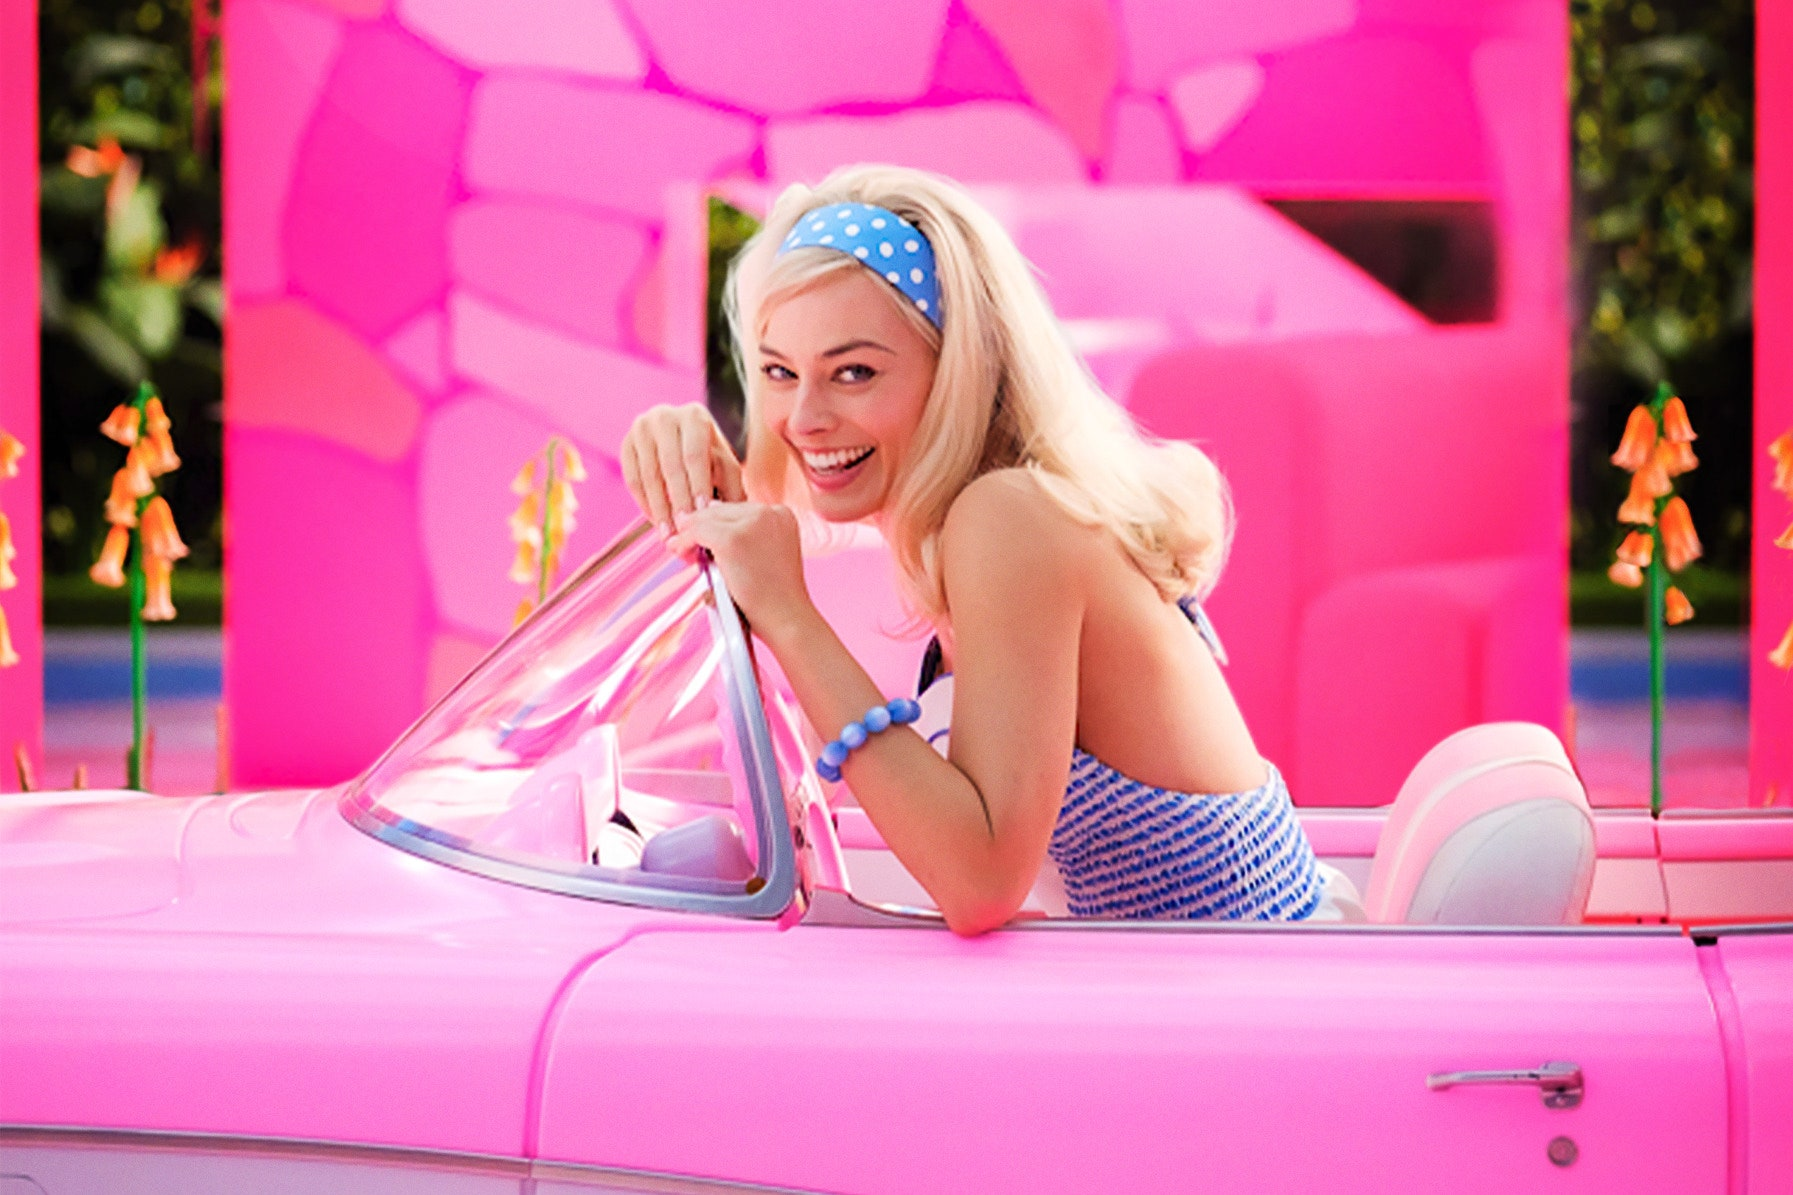

In [6]:
image